# Stock Screener
- Filter everything that has recent data (i.e. some other may be delisted)
- Filter according some criteria
- Plot

In [73]:
from matplotlib import pyplot as plt

from tradingdb.utils import *
from tradingdb.ORM.utils import *

from   datetime import datetime, timedelta

import copy

In [76]:
DBNAME=os.path.abspath("../data/master.db")
EXCHANGE="NASDAQ"

In [77]:
session=get_new_session(DBNAME)


In [43]:
# find last date
def get_last_price_for_period(stock):
    period=[]
    date=[]
    for p in stock.prices:
        date.append(p.date)
        period.append(p.period.name)
    periods=set(period)
    #print(periods)
    df=pd.DataFrame({'date':date,'period':period})
    return {pp:df[df['period'] == pp]['date'].max().to_pydatetime() for pp in periods}

stock_last_date={}
with session.begin() as mysession:
    q=mysession.query(stock.Stock).join(stock.Exchange).filter(stock.Exchange.name==EXCHANGE)
    q=q.all()
    for r in q:
        stock_last_date[r.yf_symbol]=get_last_price_for_period(r)
print(stock_last_date.items())

dict_items([('JD.L', {'1d': datetime.datetime(2023, 7, 28, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': datetime.datetime(2023, 7, 31, 16, 0)}), ('CCH.L', {'1d': datetime.datetime(2023, 7, 31, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': datetime.datetime(2023, 7, 31, 15, 0)}), ('FRES.L', {'1d': datetime.datetime(2023, 7, 28, 0, 0), '5m': datetime.datetime(2023, 7, 31, 15, 55), '1h': datetime.datetime(2023, 7, 31, 15, 0)}), ('SMT.L', {'1d': datetime.datetime(2023, 7, 28, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': datetime.datetime(2023, 7, 31, 16, 0)}), ('NXT.L', {'1d': datetime.datetime(2023, 7, 28, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': datetime.datetime(2023, 7, 31, 16, 0)}), ('RR.L', {'1d': datetime.datetime(2023, 7, 28, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': datetime.datetime(2023, 7, 31, 16, 0)}), ('ADM.L', {'1d': datetime.datetime(2023, 7, 31, 0, 0), '5m': datetime.datetime(2023, 7, 31, 16, 0), '1h': 

In [44]:
# find last date for 1h

#MYPERIOD='1h'
MYPERIOD='5m'

maxdate=datetime(1900, 7, 28, 0, 0)
for k,v in stock_last_date.items():
     try:
          if v[MYPERIOD]>maxdate: maxdate=v[MYPERIOD] 
     except:
          continue # discontinued symbols
print(maxdate)
# find all the symbols that have this as maxdate
yf_symbols=[]
for k,v in stock_last_date.items():
     try:
      if v[MYPERIOD]==maxdate: yf_symbols.append(k)
     except:
         continue
     

2023-07-31 16:00:00


In [45]:
print(yf_symbols)

['JD.L', 'CCH.L', 'SMT.L', 'NXT.L', 'RR.L', 'ADM.L', 'MRO.L', 'SN.L', 'III.L', 'BEZ.L', 'RKT.L', 'HLN.L', 'FCIT.L', 'CNA.L', 'PSH.L', 'INF.L', 'TSCO.L', 'WPP.L', 'SMDS.L', 'CRH.L', 'MNG.L', 'ABDN.L', 'IMB.L', 'BME.L', 'PSON.L', 'HL.L', 'ANTO.L', 'ULVR.L', 'GSK.L', 'DGE.L', 'IHG.L', 'BARC.L', 'AAL.L', 'PRU.L', 'HSBA.L', 'ENT.L', 'RIO.L', 'KGF.L', 'SBRY.L', 'ITRK.L', 'PHNX.L', 'UTG.L', 'BATS.L', 'BA.L', 'SGE.L', 'NG.L', 'CPG.L', 'BLND.L', 'CTEC.L', 'SSE.L', 'AV.L', 'MNDI.L', 'EDV.L', 'SHEL.L', 'NWG.L', 'LAND.L', 'VOD.L', 'ABF.L', 'LSEG.L', 'GLEN.L', 'BRBY.L', 'FLTR.L', 'AZN.L', 'STAN.L', 'LGEN.L', 'BP.L', 'REL.L', 'SGRO.L', 'SPX.L', 'WEIR.L', 'CRDA.L', 'WTB.L', 'FRAS.L', 'EXPN.L', 'UU.L', 'RS1.L', 'SVT.L', 'LLOY.L', 'BKG.L', 'IAG.L', 'AHT.L', 'RTO.L', 'DCC.L', 'TW.L', 'SDR.L', 'AUTO.L', 'HLMA.L', 'RMV.L', 'OCDO.L', 'PSN.L', 'BDEV.L', 'HSX.L', 'JMAT.L', 'IMI.L']


In [46]:
## Now loop over the symbols and get the last N bars
dfinal={}
with session.begin() as mysession:
    for yf_symbol in yf_symbols:
        ohlcv={
            'date':[],
            'open':[],
            'close':[],
            'high':[],
            'low':[],
            'volume':[]
        }
        q=mysession.query(stock.Price)
        q=q.join(stock.Stock)
        q=q.join(stock.Period)
        q=q.filter(stock.Period.name==MYPERIOD)
        q=q.filter(stock.Stock.yf_symbol==yf_symbol)
        q=q.order_by(stock.Price.date.desc())
        q=q.limit(50)
        q=q.all()
        for r in q:
            for k in ohlcv.keys():
                ohlcv[k].append(getattr(r,k))
        dfinal[yf_symbol]=pd.DataFrame.from_dict(ohlcv)

        

In [50]:
# now loop and plot

import mplfinance as fplt

print("MPLFinance Version : {}".format(fplt.__version__))


MPLFinance Version : 0.12.9b7


In [48]:
import requests
import yfinance

import json

with open("../alphavantage.json", "r") as json_file:
    data = json_file.read()

# Step 3: Use 'json.loads()' to convert the JSON data into a Python dictionary
ALPHAVANTAGE_KEY = json.loads(data)["ALPHAVANTAGE_KEY"]

def get_latest_news(symbol,av_key):

    # API endpoint for Alpha Vantage's financial news
    endpoint = "https://www.alphavantage.co/query"
    api_key = av_key  # Get your API key from https://www.alphavantage.co/support/#api-key

    # Parameters for the API request
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": "1d",  # Use any appropriate interval for intraday data
        "apikey": api_key
    }

    # Make the API request
    response = requests.get(endpoint, params=params)
    news_data = response.json()

    # Extract the latest news (if available) from the API response
    latest_news = news_data.get("News", {})

    return latest_news

CCH.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.69  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


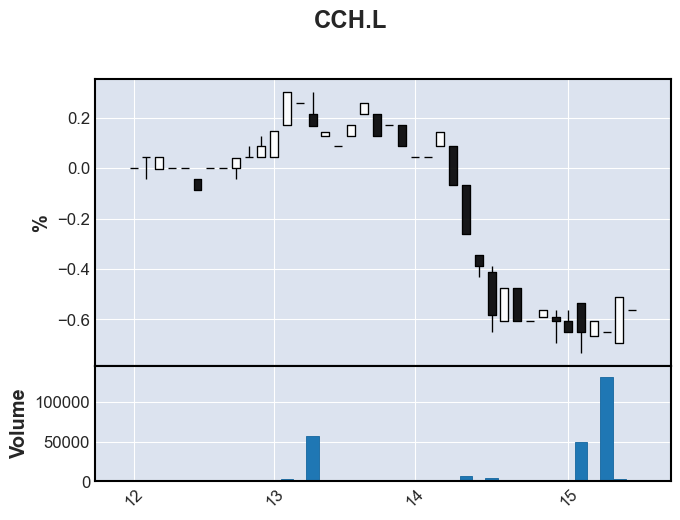

('Coca-Cola HBC AG',)
RR.L  : SELL! the overall increase in the last N bars is above threshold  13
Total Change:     -0.93  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


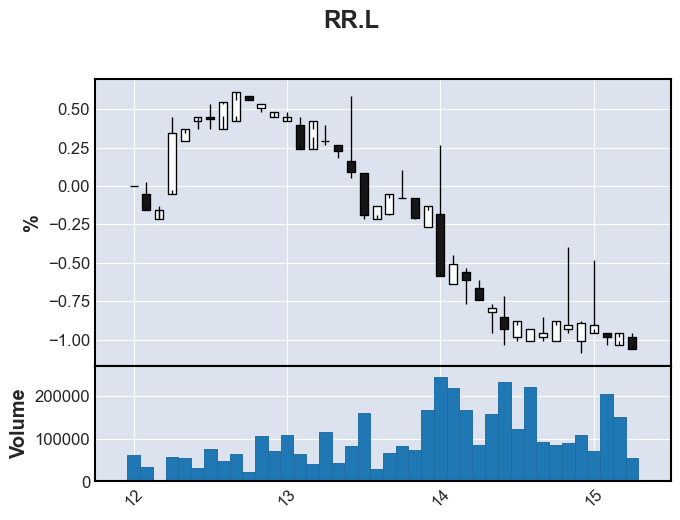

('Rolls-Royce Holdings plc',)
SN.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.63  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


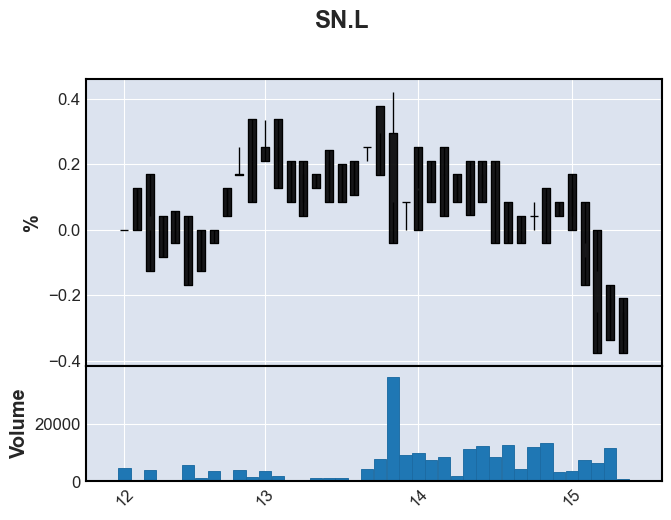

('Smith & Nephew plc',)
III.L  : SELL! the overall increase in the last N bars is above threshold  12
Total Change:     -0.50  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


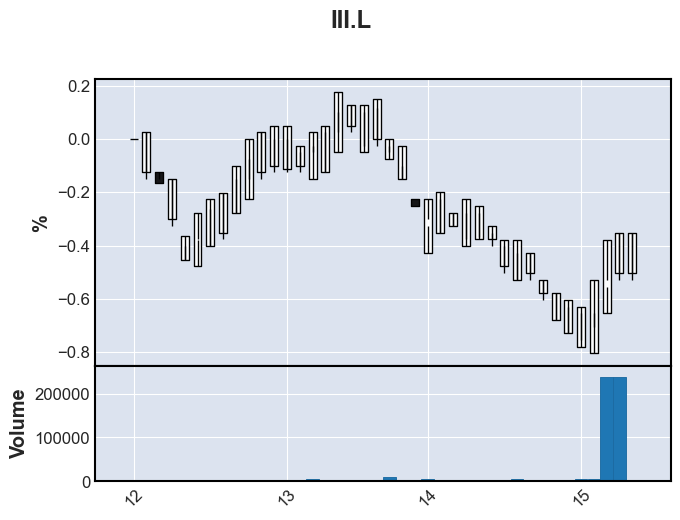

('3i Group plc',)
HLN.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.98  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


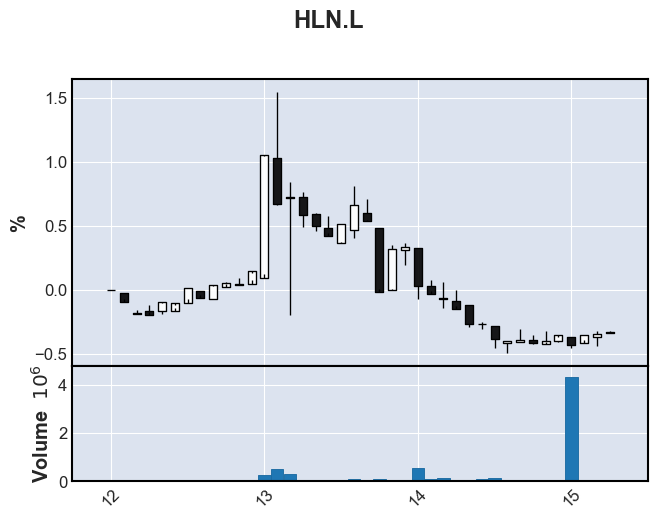

('Haleon plc',)
CNA.L  : SELL! the overall increase in the last N bars is above threshold  10
Total Change:     -1.03  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


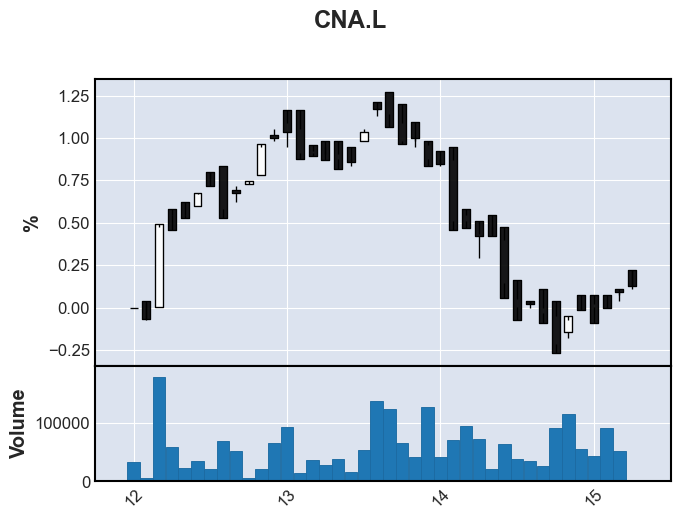

('Centrica plc',)
PSON.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.80  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


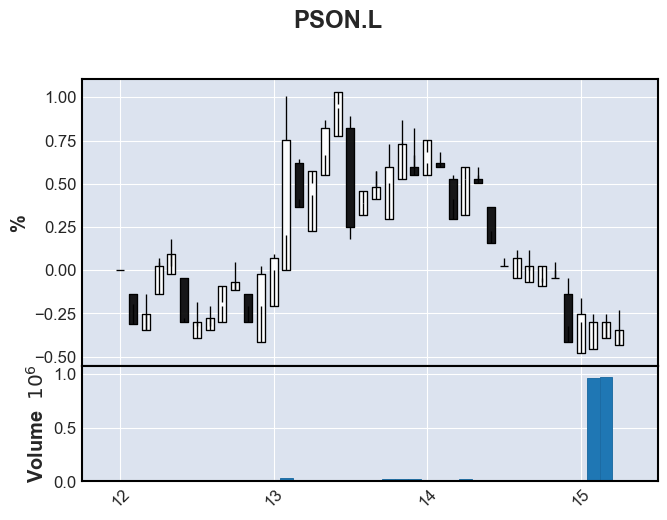

('Pearson plc',)
ANTO.L  : BUY! the overall increase in the last N bars is above threshold  11
Total Change:      0.60  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


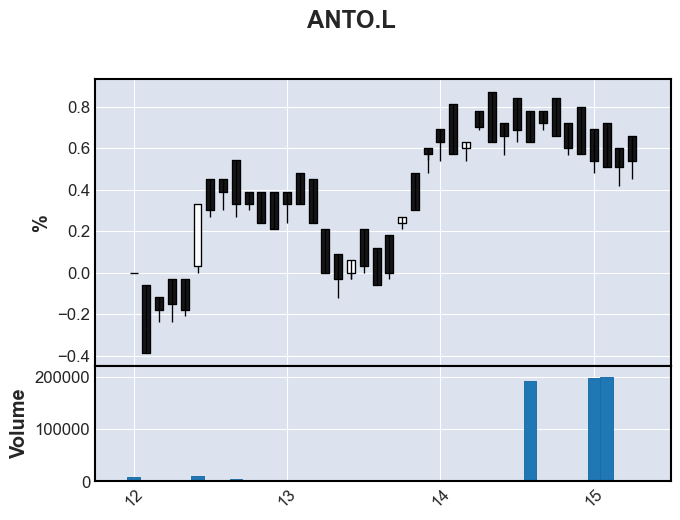

('Antofagasta plc',)
GSK.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.56  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


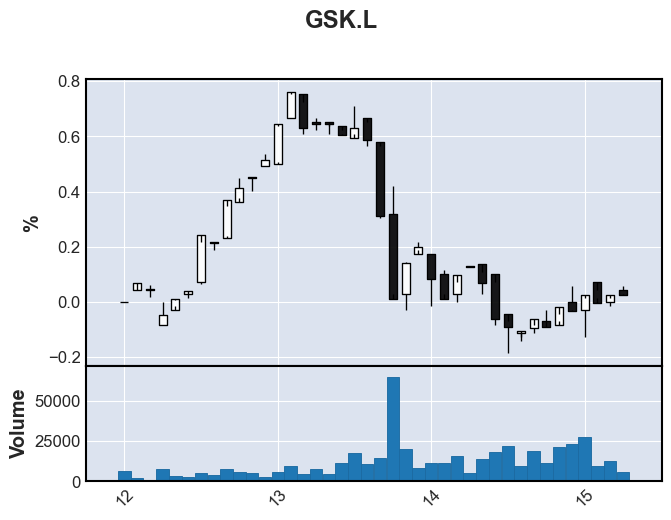

('GSK plc',)
ENT.L  : BUY! the overall increase in the last N bars is above threshold  11
Total Change:      0.73  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


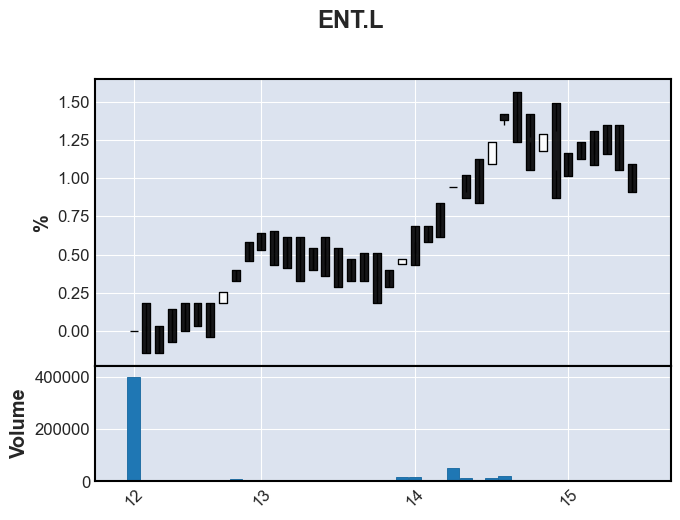

('Entain Plc',)
EDV.L  : BUY! the overall increase in the last N bars is above threshold  10
Total Change:      1.13  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


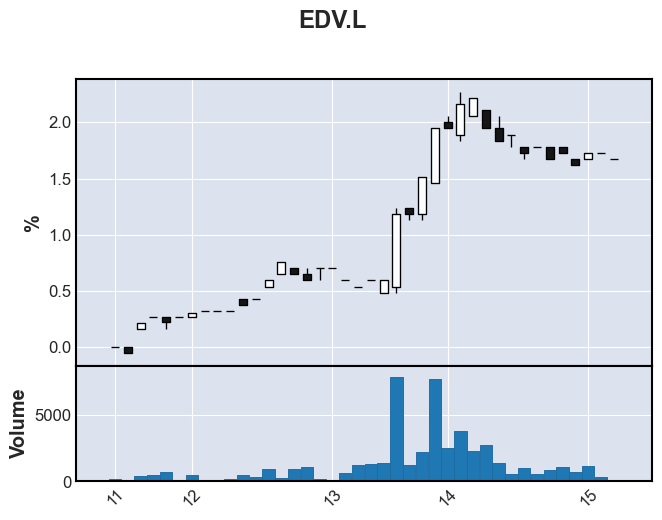

('Endeavour Mining plc',)
SHEL.L  : BUY! the overall increase in the last N bars is above threshold  11
Total Change:      0.68  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


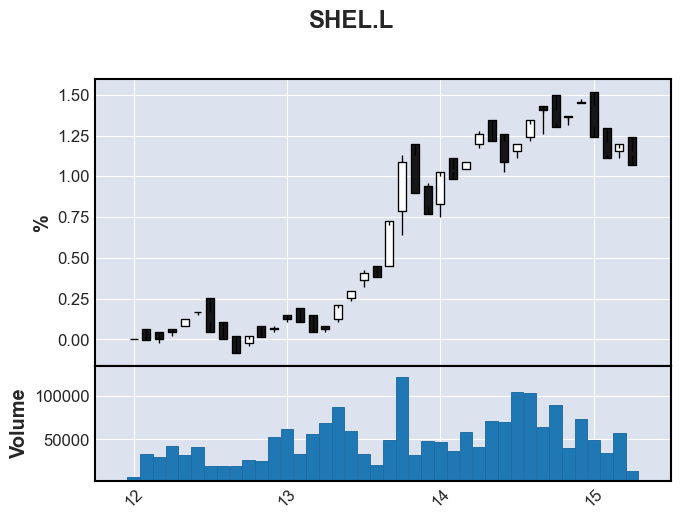

('Shell plc',)
STAN.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.91  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


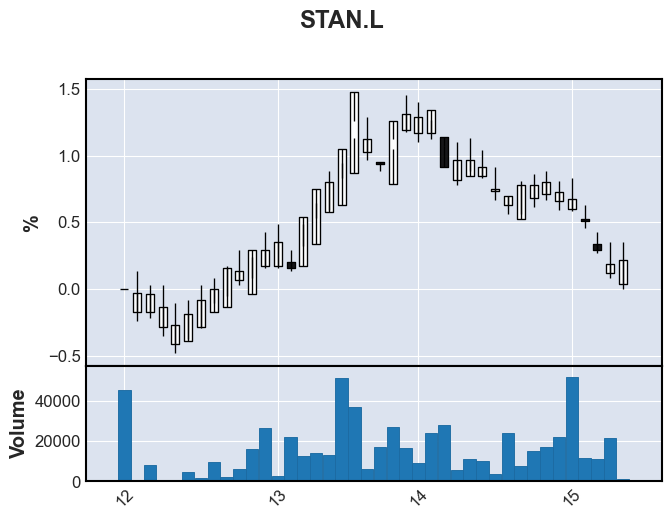

('Standard Chartered PLC',)
BP.L  : BUY! the overall increase in the last N bars is above threshold  11
Total Change:      1.19  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


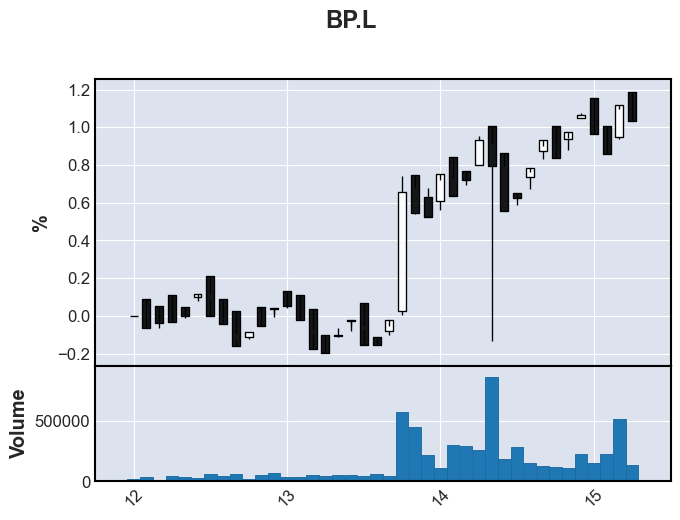

('BP p.l.c.',)
WEIR.L  : BUY! the overall increase in the last N bars is above threshold  12
Total Change:      1.07  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


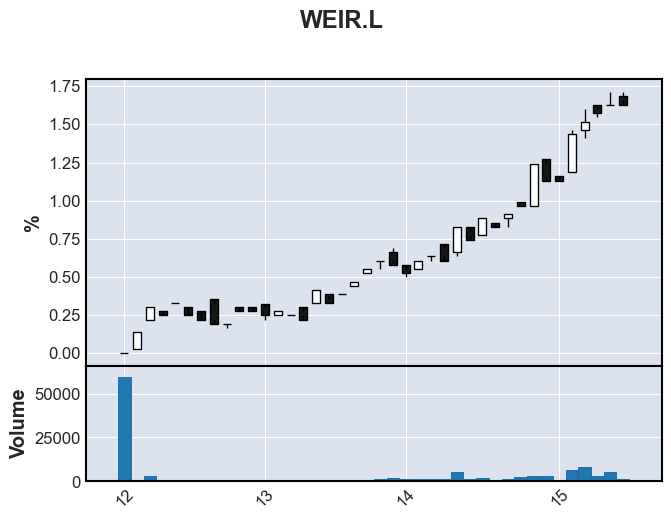

('The Weir Group PLC',)
TW.L  : SELL! the overall increase in the last N bars is above threshold  11
Total Change:     -0.72  %


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_67575/3849770267.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


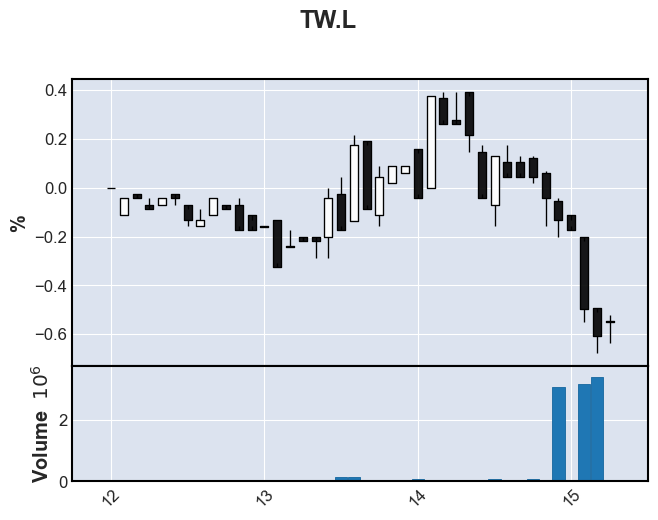

('Taylor Wimpey plc',)


In [72]:
def trendbar(row):
    if row.name == 0:  # First row, no previous row available
        return 0
    else:
        previous_r_close = df.iloc[row.name - 1]['open']
        previous_r_open = df.iloc[row.name - 1]['open']
        #print(previous_r_close)
        if previous_r_close>previous_r_open: # positive previous bar
            if previous_r_close<row['close']:
                return 1
        else: # negative previous bar
            if previous_r_close<row['open']:
                return -1
        return 0      
    
LAST_N=20
POSITIVE_N=10
CHANGET=0.005
for k,v in dfinal.items():
    df=copy.deepcopy(v)
    df['Datetime'] = pd.to_datetime(df['date'])
    df = df.set_index('Datetime')
    #print(df)
    df = df.sort_index(ascending=True)

    df['Close_Percentage_Change'] = df['close'].pct_change()

    last_N_bars_change = df['Close_Percentage_Change'].tail(LAST_N)
    overall_change = last_N_bars_change.sum()

    last_N_positive = df['Close_Percentage_Change'].tail(LAST_N).gt(0).sum()

    last_N_negative = df['Close_Percentage_Change'].tail(LAST_N).lt(0).sum()

    #df['trendbar']=df.reset_index(drop=True, inplace=False).apply(trendbar,axis=1)

    if (overall_change >= CHANGET and last_N_positive >= POSITIVE_N ) or (overall_change <= -CHANGET  and last_N_negative>= POSITIVE_N):

        if last_N_negative>= POSITIVE_N:
            print(k," : SELL! the overall increase in the last N bars is above threshold ",last_N_negative)

        elif last_N_positive >= POSITIVE_N:
            print(k," : BUY! the overall increase in the last N bars is above threshold ",last_N_positive)

        print("Total Change: ","%8.2f "%(overall_change*100.),"%")
        df=df[-LAST_N*2:]
        ticks = pd.date_range(df.index.to_list()[0],df.index.to_list()[-1],freq='1H')

        ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]
        #ticklabels = [ tick.time().strftime('%H:%M') for tick in ticks ]
        ticklabels = [ tick.time().strftime('%H') for tick in ticks ]

        for kk in ['open','close','high','low']:
            df[kk]=(df[kk]-df[kk][0])*100./df[kk][0]


        # Create the additional plot using make_addplot()
        #add_plot = fplt.make_addplot(df['trendbar'], panel=2, color='orange', secondary_y=False)

        fig,ax =fplt.plot(
                    df,
                    type='candle',
                    title=k,
                    #ylabel='Points',
                    ylabel='%',
                    volume=True,
                    returnfig=True,
                    #addplot=add_plot
                )


        ax[0].xaxis.set_ticks(ticklocations)
        ax[0].set_xticklabels(ticklabels)

        fplt.show()

        with session.begin() as mysession:
            q=mysession.query(stock.Stock.company)
            q=q.filter(stock.Stock.yf_symbol==k)
            q=q.one()
            print(q)

        #print(get_latest_news(k,ALPHAVANTAGE_KEY))
        #break

In [ ]:
rint